In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image


import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-10-02 15:25:25.488058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759418725.677071      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759418725.729642      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

data_dir = '/kaggle/input/luekemia-detection-blood-smear-images/augumented_dataset'

filepaths = []
labels = []

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    
   
    if not os.path.isdir(folder_path):
        continue
    
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        filepaths.append(file_path)
        labels.append(folder_name) 


df = pd.DataFrame({
    'filepaths': filepaths,
    'labels': labels
})



df['labels'] = df['labels'].map({'healthy': 0, 'cancerous': 1})

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)


print("Total images:", len(df))
print("Training set:", len(train_df))
print("Validation set:", len(val_df))
print("Sample data:\n", train_df.head())


Total images: 10000
Training set: 8000
Validation set: 2000
Sample data:
                                               filepaths  labels
5808  /kaggle/input/luekemia-detection-blood-smear-i...       0
3617  /kaggle/input/luekemia-detection-blood-smear-i...       1
7869  /kaggle/input/luekemia-detection-blood-smear-i...       0
5250  /kaggle/input/luekemia-detection-blood-smear-i...       1
3191  /kaggle/input/luekemia-detection-blood-smear-i...       0


In [3]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)


valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [4]:

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'raw',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'raw',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'raw',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames.
Found 1200 validated image filenames.
Found 800 validated image filenames.


In [5]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15),
])


I0000 00:00:1759418781.298165      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate

# Image shape
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Input tensor
inp = Input(shape=img_shape)

# Backbones
base1 = tf.keras.applications.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="avg"
)
base2 = tf.keras.applications.ResNet152V2(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="avg"
)
base3 = tf.keras.applications.ConvNeXtTiny(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="avg"
)

# Freeze all layers
for base in [base1, base2, base3]:
    base.trainable = False
    # Unfreeze top 50 layers
    for layer in base.layers[-50:]:
        layer.trainable = True

# Extract features
f1 = base1(inp)
f2 = base2(inp)
f3 = base3(inp)

# Merge features
merged = Concatenate()([f1, f2, f3])

# Dense head
x = BatchNormalization()(merged)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)

# Model
model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb3      │ (None, 1536)      │ 10,783,535 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152v2         │ (None, 2048)      │ 58,331,648 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny       │ (None, 768)       │ 27,820,128 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4352)      │          0 │ efficientnetb3[0… │
│ (Concatenate)       │                   │            │ resnet152v2[0][0… │
│                     │                   │            │ convnext_tiny[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4352)      │     17,408 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,228,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,181,968 (378.35 MB)

 Trainable params: 43,314,101 (165.23 MB)

 Non-trainable params: 55,867,867 (213.12 MB)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15


I0000 00:00:1759418900.659114      98 service.cc:148] XLA service 0x7845ac0021b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759418900.660009      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759418911.207893      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1759418921.749761      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759418921.966872      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759418922.345543      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759418922.5625

500/500 ━━━━━━━━━━━━━━━━━━━━ 283s 285ms/step - accuracy: 0.7965 - auc: 0.8706 - loss: 0.4719 - val_accuracy: 0.8983 - val_auc: 0.9561 - val_loss: 0.2551 - learning_rate: 1.0000e-04
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/step - accuracy: 0.8869 - auc: 0.9527 - loss: 0.2736 - val_accuracy: 0.8358 - val_auc: 0.9651 - val_loss: 0.4513 - learning_rate: 1.0000e-04
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 229ms/step - accuracy: 0.9243 - auc: 0.9745 - loss: 0.1972 - val_accuracy: 0.9058 - val_auc: 0.9617 - val_loss: 0.2436 - learning_rate: 1.0000e-04
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/step - accuracy: 0.9370 - auc: 0.9795 - loss: 0.1771 - val_accuracy: 0.8383 - val_auc: 0.9678 - val_loss: 0.3686 - learning_rate: 1.0000e-04
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/step - accuracy: 0.9573 - auc: 0.9913 - loss: 0.1167 - val_accuracy: 0.9000 - val_auc: 0.9597 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 114s 228ms/

In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np


preds = model.predict(test_gen)          
pred_labels = (preds > 0.7).astype(int).flatten()  


true_labels = test_gen.labels  
acc = accuracy_score(true_labels, pred_labels)
cm = confusion_matrix(true_labels, pred_labels)
cr = classification_report(true_labels, pred_labels)

print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)


50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step
Accuracy: 0.9350
Confusion Matrix:
 [[398  17]
 [ 35 350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       415
           1       0.95      0.91      0.93       385

    accuracy                           0.94       800
   macro avg       0.94      0.93      0.93       800
weighted avg       0.94      0.94      0.93       800



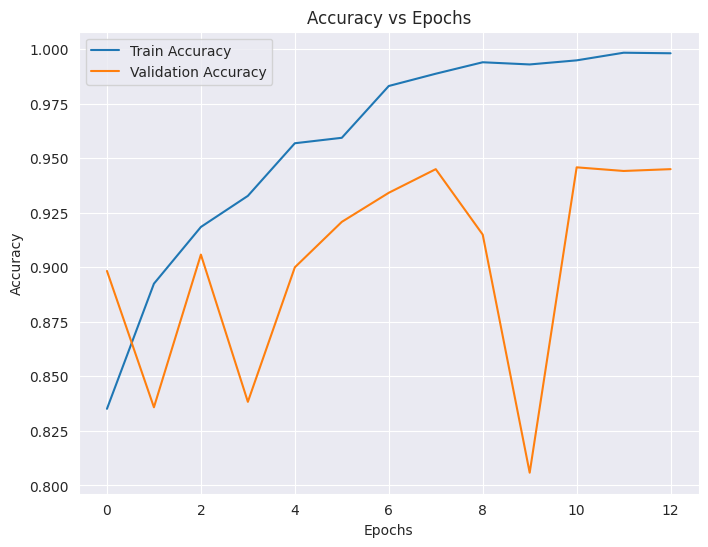

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


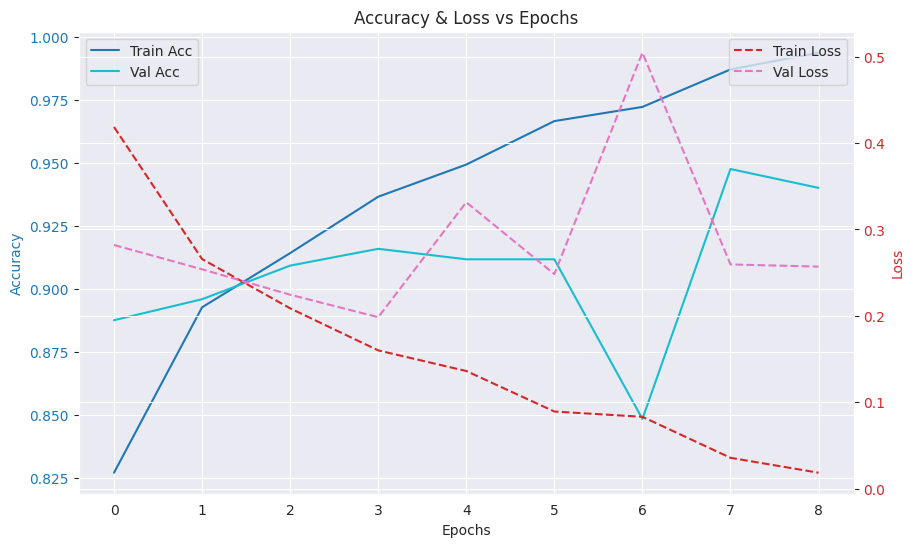

In [9]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(history.history['accuracy'], label='Train Acc', color='tab:blue')
ax1.plot(history.history['val_accuracy'], label='Val Acc', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Loss', color=color)
ax2.plot(history.history['loss'], label='Train Loss', color='tab:red', linestyle='--')
ax2.plot(history.history['val_loss'], label='Val Loss', color='tab:pink', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Accuracy & Loss vs Epochs')
plt.grid(True)
plt.show()


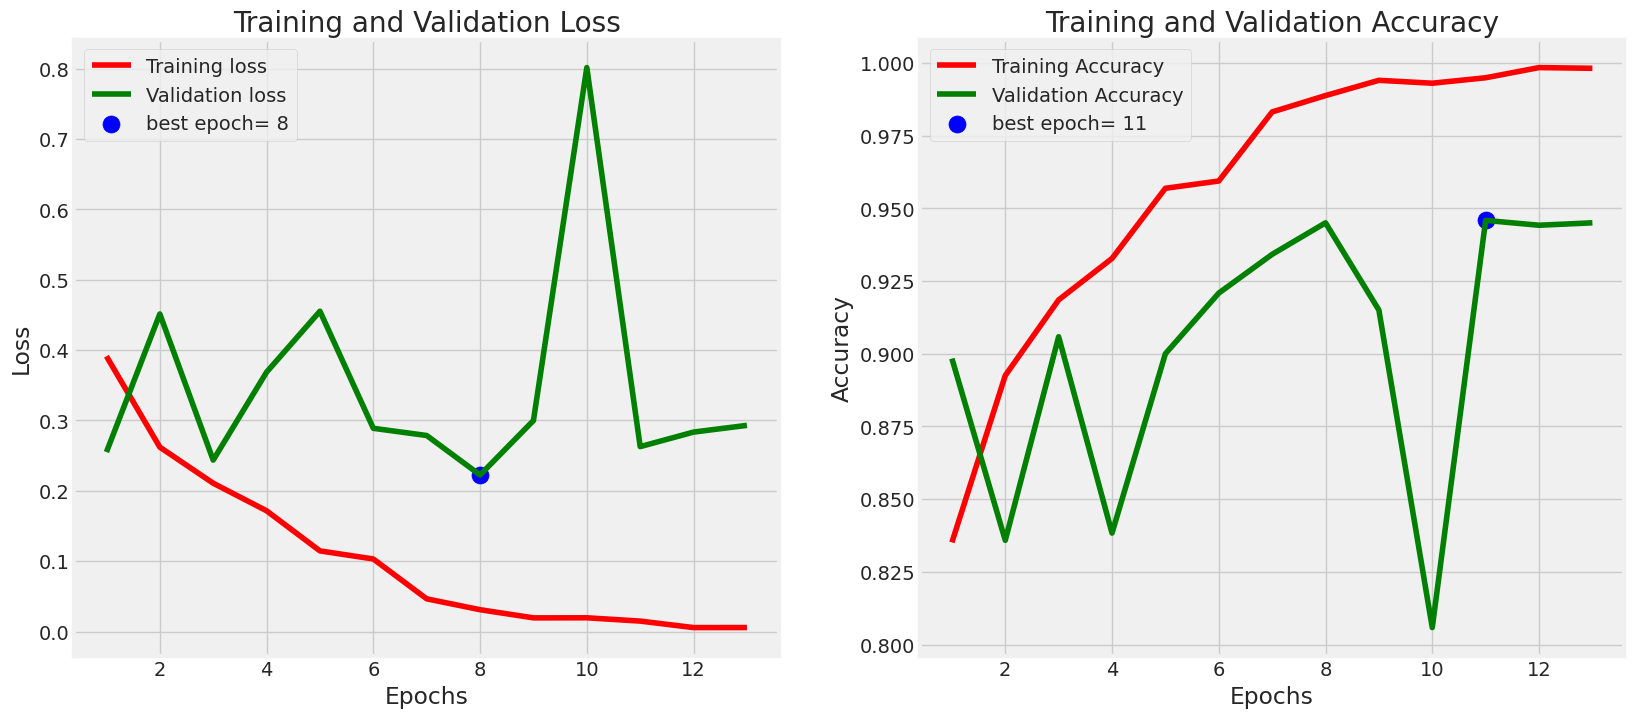

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

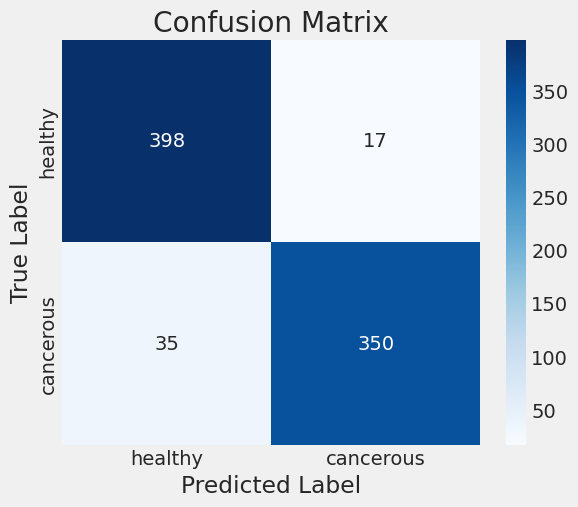

In [15]:
class_names=["healthy","cancerous"]
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('/kaggle/working/.h5')